# 1. Import Libraries

In [6]:
!pip install category_encoders

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from math import sqrt
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
data = pd.read_csv("data/train.csv")
data_test =  pd.read_csv("data/test.csv")
data_test['SalePrice'] =0 
data_train = pd.concat([data,data_test])
data.shape, data_test.shape, data_train.shape

((1460, 81), (1459, 81), (2919, 81))

In [9]:
#real training set #data_train = data_train.iloc[1460:]

In [10]:
data_train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


# 2. Feature Cleaning and Engineering

## 2.1: Drop Unnecesary Columns

In [11]:
#drop columns with lot of nan and without any important information
drop_col = ['Id','Street','Alley','Utilities','Condition2','RoofMatl','Heating','MiscFeature','PoolQC']
data_train.drop(columns=drop_col,inplace=True)

In [12]:
# numerical columns
data_train.select_dtypes(include=np.number).head(2)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007,181500


In [13]:
#categorical columns
data_train[list(set(data_train.columns) - set(data_train.select_dtypes(include=np.number).columns))].head(2)

,Neighborhood,PavedDrive,HouseStyle,BsmtFinType2,SaleCondition,BsmtExposure,ExterQual,KitchenQual,Foundation,GarageType,BsmtQual,LandSlope,Exterior1st,LotConfig,LandContour,GarageFinish,CentralAir,Condition1,SaleType,RoofStyle,Exterior2nd,BsmtFinType1,LotShape,Functional,BldgType,HeatingQC,BsmtCond,MasVnrType,ExterCond,GarageCond,MSZoning,Fence,FireplaceQu,Electrical,GarageQual
0,CollgCr,Y,2Story,Unf,Normal,No,Gd,Gd,PConc,Attchd,Gd,Gtl,VinylSd,Inside,Lvl,RFn,Y,Norm,WD,Gable,VinylSd,GLQ,Reg,Typ,1Fam,Ex,TA,BrkFace,TA,TA,RL,NaN,NaN,SBrkr,TA
1,Veenker,Y,1Story,Unf,Normal,Gd,TA,TA,CBlock,Attchd,Gd,Gtl,MetalSd,FR2,Lvl,RFn,Y,Feedr,WD,Gable,MetalSd,ALQ,Reg,Typ,1Fam,Ex,TA,None,TA,TA,RL,NaN,TA,SBrkr,TA


In [14]:
#test 
data_train.shape[1] == data_train.select_dtypes(include=np.number).shape[1] + data_train[list(set(data_train.columns) - set(data_train.select_dtypes(include=np.number).columns))].shape[1]

True

## 2.2 Fill nan values

In [15]:
pd.DataFrame(data_train.isna().sum()).T

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,4,486,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,24,23,0,0,0,81,82,82,79,1,80,1,1,1,0,0,1,0,0,0,0,2,2,0,0,0,0,1,0,2,0,1420,157,159,159,1,1,159,159,0,0,0,0,0,0,0,2348,0,0,0,1,0,0


In [16]:
# fill No garage with 2000, we will use this number to indicate that the garage does not exist
data_train['GarageYrBlt'] = data_train['GarageYrBlt'].fillna(2000)

# categorical features with missing values in the data.
data_train['MSZoning'].fillna(data_train['MSZoning'].mode().iloc[0], inplace=True)
data_train['Exterior1st'].fillna(data_train['Exterior1st'].mode().iloc[0], inplace=True)
data_train['Exterior2nd'].fillna(data_train['Exterior2nd'].mode().iloc[0], inplace=True)
data_train['MasVnrType'].fillna(data_train['MasVnrType'].mode().iloc[0], inplace=True)
data_train['Electrical'].fillna(data_train['Electrical'].mode().iloc[0], inplace=True)
data_train['KitchenQual'].fillna(data_train['KitchenQual'].mode().iloc[0], inplace=True)
data_train['Functional'].fillna(data_train['Functional'].mode().iloc[0], inplace=True)
data_train['SaleType'].fillna(data_train['SaleType'].mode().iloc[0], inplace=True)

#fill categorical features with "no_value" because it actually do not exist. nothing is missing in the data 
fill_with_no_val = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                               'BsmtFinType2','GarageFinish',
                               'GarageQual','GarageCond','Fence','GarageType','FireplaceQu']
data_train[fill_with_no_val] = data_train[fill_with_no_val].fillna('no_val')

data_train['LotFrontage'].fillna(0, inplace=True)

# missing values in numerical data which are actually missing
data_train['BsmtFinSF1'].fillna(data_train['BsmtFinSF1'].median(), inplace=True)
data_train['MasVnrArea'].fillna(data_train['MasVnrArea'].median(), inplace=True)
data_train['BsmtFinSF2'].fillna(data_train['BsmtFinSF2'].median(), inplace=True)
data_train['BsmtUnfSF'].fillna(data_train['BsmtUnfSF'].median(), inplace=True)
data_train['TotalBsmtSF'].fillna(data_train['TotalBsmtSF'].median(), inplace=True)
data_train['BsmtFullBath'].fillna(data_train['BsmtFullBath'].median(), inplace=True)
data_train['BsmtHalfBath'].fillna(data_train['BsmtHalfBath'].median(), inplace=True)
data_train['GarageArea'].fillna(data_train['GarageArea'].median(), inplace=True)
data_train['GarageCars'].fillna(data_train['GarageCars'].median(), inplace=True)


In [17]:
#test
pd.DataFrame(data_train.isna().sum()).T

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 2.3 work on numerical features

In [18]:
# 37 numerical features
data_train[data_train.select_dtypes(include=np.number).columns].shape

(2919, 37)

In [19]:
data_train['remod_after_built'] = data_train['YearRemodAdd'] - data_train['YearBuilt']
data_train.drop(columns=['YearRemodAdd'],inplace=True)

data_train['MSSubClass'] =data_train['MSSubClass'].astype(str) 

In [20]:
def replace_low_pred_others(data_train,feature,precentage):
  return data_train[feature].mask(data_train[feature].map(data_train[feature].value_counts(normalize=True)*100) < precentage, 'Other')

In [21]:
print(data_train['YearBuilt'].min(), data_train['YearBuilt'].max())
print(data_train['YrSold'].min(), data_train['YrSold'].max())
print(data_train['GarageYrBlt'].min(), data_train['GarageYrBlt'].max())

1872 2010
2006 2010
1895.0 2207.0


In [22]:
#create bins
bins = [1870,1913,1927,1941, 1954,1968,1982,1996,2020]
data_train['YearBuilt'] = pd.cut(data_train['YearBuilt'], bins)
bins = [2005,2007,2009,2011]
data_train['YrSold'] = pd.cut(data_train['YrSold'], bins)

In [23]:
bins = [1892,2002,2005,2520]
data_train['GarageYrBlt'] = pd.cut(data_train['GarageYrBlt'], bins)

## 2.4 categorical columns

In [24]:
data_train[list(set(data_train.columns) - set(data_train.select_dtypes(include=np.number).columns))].head(2)

,Neighborhood,PavedDrive,HouseStyle,BsmtFinType2,SaleCondition,BsmtExposure,ExterQual,KitchenQual,Foundation,GarageType,BsmtQual,LandSlope,Exterior1st,LotConfig,LandContour,GarageFinish,CentralAir,Condition1,SaleType,RoofStyle,Exterior2nd,BsmtFinType1,LotShape,Functional,BldgType,HeatingQC,BsmtCond,MasVnrType,ExterCond,GarageYrBlt,GarageCond,MSZoning,Fence,FireplaceQu,YrSold,Electrical,YearBuilt,GarageQual,MSSubClass
0,CollgCr,Y,2Story,Unf,Normal,No,Gd,Gd,PConc,Attchd,Gd,Gtl,VinylSd,Inside,Lvl,RFn,Y,Norm,WD,Gable,VinylSd,GLQ,Reg,Typ,1Fam,Ex,TA,BrkFace,TA,"(2002, 2005]",TA,RL,no_val,no_val,"(2007, 2009]",SBrkr,"(1996, 2020]",TA,60
1,Veenker,Y,1Story,Unf,Normal,Gd,TA,TA,CBlock,Attchd,Gd,Gtl,MetalSd,FR2,Lvl,RFn,Y,Feedr,WD,Gable,MetalSd,ALQ,Reg,Typ,1Fam,Ex,TA,None,TA,"(1892, 2002]",TA,RL,no_val,TA,"(2005, 2007]",SBrkr,"(1968, 1982]",TA,20


In [25]:
categ_one_hot_enc = ['Condition1','Neighborhood','MasVnrType','LotShape','BldgType','LandSlope','MSZoning','Electrical','RoofStyle',
                     'LandContour','YrSold','GarageYrBlt','LotConfig','SaleType','GarageType','Functional','HouseStyle','GarageFinish','Exterior2nd','Exterior1st','Foundation','MSSubClass','YearBuilt'
                     ,'PavedDrive']
                     
label_encoding = ['ExterQual','FireplaceQu','BsmtFinType1','ExterCond','GarageQual','GarageCond','KitchenQual','HeatingQC',
                  'SaleCondition','CentralAir','BsmtCond','BsmtQual','Fence','BsmtExposure','BsmtFinType2']

In [26]:
#test
len(categ_one_hot_enc) + len(label_encoding) == len(data_train[list(set(data_train.columns) - set(data_train.select_dtypes(include=np.number).columns))].columns)

True

In [27]:
categ_one_hot_enc = ['Condition1','Neighborhood','MasVnrType','LotShape','BldgType','LandSlope','MSZoning','Electrical','RoofStyle',
                     'LandContour','YrSold','GarageYrBlt','LotConfig','SaleType','GarageType','Functional','HouseStyle','GarageFinish','Exterior2nd','Exterior1st','Foundation','MSSubClass','YearBuilt'
                     ,'PavedDrive']
                     
label_encoding = ['ExterQual','FireplaceQu','BsmtFinType1','ExterCond','GarageQual','GarageCond','KitchenQual','HeatingQC',
                  'SaleCondition','CentralAir','BsmtCond','BsmtQual','Fence','BsmtExposure','BsmtFinType2']


## 2.5 Filter low frequency values and encode to numerical

In [28]:
data_train['Condition1'].value_counts(normalize=True)*100

Norm      86.022610
Feedr      5.618362
Artery     3.151764
RRAn       1.712915
PosN       1.336074
RRAe       0.959233
PosA       0.685166
RRNn       0.308325
RRNe       0.205550
Name: Condition1, dtype: float64

In [29]:
data_train[categ_one_hot_enc] = data_train[categ_one_hot_enc].astype(str)

data_train['Condition1'] = replace_low_pred_others(data_train,'Condition1',3)
data_train['Neighborhood'] = replace_low_pred_others(data_train,'Neighborhood',3) # can be commented
data_train['Exterior1st'] = replace_low_pred_others(data_train,'Exterior1st',2)
data_train['Foundation'] = replace_low_pred_others(data_train,'Foundation',2)
data_train['MSZoning'] = replace_low_pred_others(data_train,'MSZoning',4)
data_train['RoofStyle'] = replace_low_pred_others(data_train,'RoofStyle',2)
data_train['SaleType'] = replace_low_pred_others(data_train,'SaleType',2)
data_train['GarageType'] = replace_low_pred_others(data_train,'GarageType',5)
data_train['Functional'] = replace_low_pred_others(data_train,'Functional',2)
data_train['HouseStyle'] = replace_low_pred_others(data_train,'HouseStyle',4)
data_train['Exterior2nd'] = replace_low_pred_others(data_train,'Exterior2nd',4)

In [30]:
encoder= ce.BaseNEncoder(cols=categ_one_hot_enc,return_df=True,base=2)
data_train = encoder.fit_transform(data_train)
data_train.shape

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


(2919, 132)

In [31]:
map_dict_Ex_Po = {'Ex': 5,  'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,'no_val':0}
map_dict_GLQ_Unf = {'GLQ': 6,  'ALQ': 5, 'BLQ': 4, 'Rec': 3,  'LwQ':2, 'Unf': 1, 'no_val':0}
map_dict_normal_Partial= {'Normal': 6,  'Abnorml': 5, 'AdjLand': 4, 'Alloca': 3,   'Family': 2,'Partial':1,	 'no_val':0}
map_dict_Y_P_N = {'Y' : 3, 'P':2, 'N':0,'no_val':0 }
map_dict_Y_N = {'Y' : 1, 'N':0 }
map_dict_Gd_MN = {'GdPrv': 4,  'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'no_val':0}
map_dict_Gd_No = {'Gd': 4,  'Av': 3, 'Mn': 2, 'No': 1, 'no_val':0}

In [32]:
data_train[['ExterQual','FireplaceQu','ExterCond','GarageQual','GarageCond','KitchenQual','HeatingQC','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
            'SaleCondition', 'CentralAir','CentralAir','Fence','BsmtExposure']].head(3)

,ExterQual,FireplaceQu,ExterCond,GarageQual,GarageCond,KitchenQual,HeatingQC,BsmtCond,BsmtQual,BsmtFinType1,BsmtFinType2,SaleCondition,CentralAir,CentralAir,Fence,BsmtExposure
0,Gd,no_val,TA,TA,TA,Gd,Ex,TA,Gd,GLQ,Unf,Normal,Y,Y,no_val,No
1,TA,TA,TA,TA,TA,TA,Ex,TA,Gd,ALQ,Unf,Normal,Y,Y,no_val,Gd
2,Gd,TA,TA,TA,TA,Gd,Ex,TA,Gd,GLQ,Unf,Normal,Y,Y,no_val,Mn


In [33]:
data_train.ExterQual = data_train.ExterQual.map(map_dict_Ex_Po)
data_train.FireplaceQu = data_train.FireplaceQu.map(map_dict_Ex_Po)
data_train.ExterCond = data_train.ExterCond.map(map_dict_Ex_Po)
data_train.GarageQual = data_train.GarageQual.map(map_dict_Ex_Po)
data_train.GarageCond = data_train.GarageCond.map(map_dict_Ex_Po)
data_train.KitchenQual = data_train.KitchenQual.map(map_dict_Ex_Po)
data_train.HeatingQC = data_train.HeatingQC.map(map_dict_Ex_Po)
data_train.BsmtCond = data_train.BsmtCond.map(map_dict_Ex_Po)
data_train.BsmtQual = data_train.BsmtQual.map(map_dict_Ex_Po)
#data_train.PoolQC = data_train.PoolQC.map(map_dict_Ex_Po)

data_train.BsmtFinType1 = data_train.BsmtFinType1.map(map_dict_GLQ_Unf)
data_train.BsmtFinType2  = data_train.BsmtFinType2.map(map_dict_GLQ_Unf)

data_train.SaleCondition = data_train.SaleCondition.map(map_dict_normal_Partial)

data_train.CentralAir = data_train.CentralAir.map(map_dict_Y_N)

data_train.Fence  = data_train.Fence.map(map_dict_Gd_MN)

data_train.BsmtExposure  = data_train.BsmtExposure.map(map_dict_Gd_No)


In [34]:
data_train[['ExterQual','FireplaceQu','ExterCond','GarageQual','GarageCond','KitchenQual','HeatingQC','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
            'SaleCondition', 'CentralAir','CentralAir','Fence','BsmtExposure']].head(3)

,ExterQual,FireplaceQu,ExterCond,GarageQual,GarageCond,KitchenQual,HeatingQC,BsmtCond,BsmtQual,BsmtFinType1,BsmtFinType2,SaleCondition,CentralAir,CentralAir,Fence,BsmtExposure
0,4,0,3,3,3,4,5,3,4,6,1,6,1,1,0,1
1,3,3,3,3,3,3,5,3,4,5,1,6,1,1,0,4
2,4,3,3,3,3,4,5,3,4,6,1,6,1,1,0,2


In [35]:
min_max_scaler  = list(set(data_train.columns) -set(['SalePrice']))

# 3. **Training** with training and validation datasets

## 3.1 Train_1: select best hypermarams and best features - **Best model**

In [ ]:
data_train.head(2)

,MSSubClass_0,MSSubClass_1,MSSubClass_2,MSSubClass_3,MSSubClass_4,MSZoning_0,MSZoning_1,MSZoning_2,LotFrontage,LotArea,LotShape_0,LotShape_1,LotShape_2,LandContour_0,LandContour_1,LandContour_2,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LandSlope_0,LandSlope_1,LandSlope_2,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Condition1_0,Condition1_1,Condition1_2,BldgType_0,BldgType_1,BldgType_2,BldgType_3,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,OverallQual,OverallCond,YearBuilt_0,YearBuilt_1,YearBuilt_2,YearBuilt_3,RoofStyle_0,RoofStyle_1,RoofStyle_2,Exterior1st_0,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior2nd_0,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrArea,ExterQual,ExterCond,Foundation_0,Foundation_1,Foundation_2,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical_0,Electrical_1,Electrical_2,Electrical_3,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional_0,Functional_1,Functional_2,Fireplaces,FireplaceQu,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageYrBlt_0,GarageYrBlt_1,GarageYrBlt_2,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive_0,PavedDrive_1,PavedDrive_2,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold_0,YrSold_1,YrSold_2,SaleType_0,SaleType_1,SaleType_2,SaleCondition,SalePrice,remod_after_built
0,0,0,0,0,1,0,0,1,65.0,8450,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,7,5,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,196.0,4,3,0,0,1,4,3,1,6,706.0,1,0.0,150.0,856.0,5,1,0,0,0,1,856,854,0,1710,1.0,0.0,2,1,3,1,4,8,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,2.0,548.0,3,3,0,0,1,0,61,0,0,0,0,0,0,2,0,0,1,0,0,1,6,208500,0
1,0,0,0,1,0,0,0,1,80.0,9600,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,6,8,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0.0,3,3,0,1,0,4,3,4,5,978.0,1,0.0,284.0,1262.0,5,1,0,0,0,1,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,0,0,1,1,3,0,0,0,1,0,1,0,0,0,1,2.0,460.0,3,3,0,0,1,298,0,0,0,0,0,0,0,5,0,1,0,0,0,1,6,181500,0


In [ ]:
x_train.shape,  y_train.shape, x_valid.shape, y_valid.shape

((1168, 131), (1168,), (292, 131), (292,))

In [ ]:
data_train1 = data_train.iloc[0:1460]
data_train1.shape

X =   data_train1.drop("SalePrice",axis=1)
y = data_train1['SalePrice']

x_train, x_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

#output1: baseline
xg_reg = xgb.XGBRegressor(objective= "reg:squarederror")
xg_reg.fit(x_train, y_train)
predictions = xg_reg.predict(x_valid)
sqrt(mean_squared_error(y_valid, predictions))

28915.057934946788

In [ ]:
# Grid Search Parameters
grid_search_params = {
    'colsample_bytree': [0.1,0.2,0.3, 0.5, 0.7],
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'n_estimators': [30, 50,70, 100],
    'subsample': [0.2, 0.3, 0.5, 0.8],
    'max_depth': [3, 5,8,10]
}
xg_grid_grid = xgb.XGBRegressor(objective= "reg:squarederror")
grid = GridSearchCV(estimator=xg_grid_grid, param_grid=grid_search_params, scoring='neg_mean_squared_error',
                    cv=5, verbose=1, n_jobs = -1)

grid.fit(x_train, y_train)
print("*********************************************************************************************")
print("Best parameters found: ", grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid.best_score_)))

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 1252 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2908 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3558 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 4308 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 5158 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 6108 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 7158 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 8308 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 9558 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 9600 out of 9600 | elapsed: 27.2min finished


*********************************************************************************************
Best parameters found:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Lowest RMSE found:  28574.60292564886


In [ ]:
# grid.best_params_ = {'colsample_bytree': 0.5,
#  'learning_rate': 0.1,
#  'max_depth': 5,
#  'n_estimators': 100,
#  'subsample': 0.8}

In [ ]:
 xg_grid_grid = xgb.XGBRegressor(objective= "reg:squarederror")
xg_grid_grid.set_params(**grid.best_params_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [ ]:
# output 2: based on best params
xg_grid_grid.fit(x_train, y_train)
predictions = xg_grid_grid.predict(x_valid)
sqrt(mean_squared_error(y_valid, predictions))

24600.619259146137

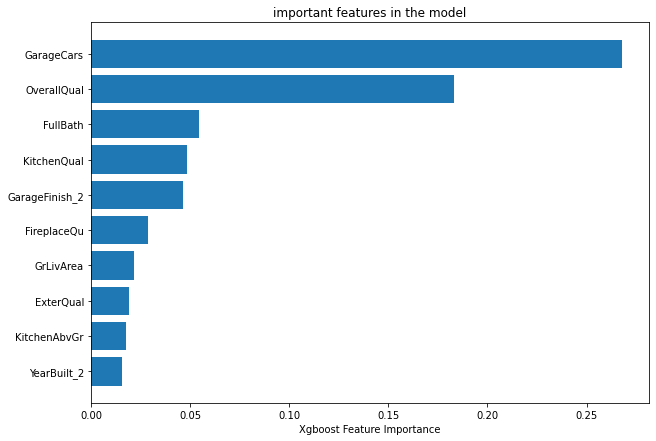

In [ ]:
#top 10 important features
plt.figure(figsize=(10,7))
sorted_idx = xg_grid_grid.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx][-10:], xg_grid_grid.feature_importances_[sorted_idx][-10:])
plt.xlabel("Xgboost Feature Importance")
plt.title("important features in the model")
plt.show()

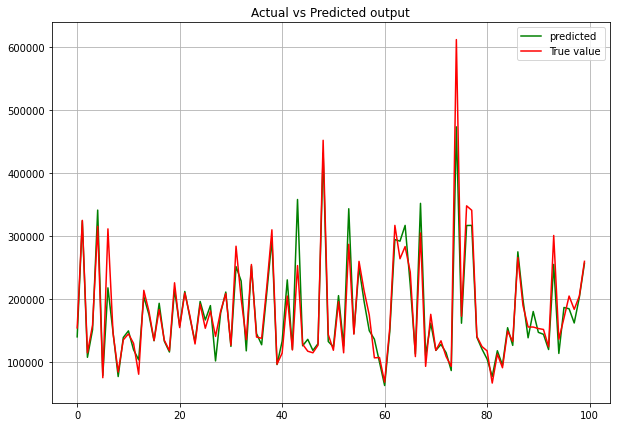

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(range(0,100), predictions[0:100],color="green",label="predicted")
plt.plot(range(0,100), y_valid[0:100],color="red",label="True value")
plt.title("Actual vs Predicted output")
plt.grid()
plt.legend()
plt.show()

## 3.2 Train_11: do the same with scaling - **Bad result**

lets scale the features and pay attention if the model performance increases

In [ ]:
data_train.shape, len(min_max_scaler)

((2919, 132), 131)

In [ ]:
ct = make_column_transformer(
   (MinMaxScaler(),min_max_scaler), #turn all values from 0 to 1
)
ct.fit(x_train)
X_train_normal = ct.transform(x_train)
X_valid_normal = ct.transform(x_valid)
#test
print(np.any(np.isnan(X_train_normal)))
print(np.any(np.isnan(X_valid_normal)))

False
False


In [ ]:
X_train_normal.shape, y_train.shape, X_valid_normal.shape, y_valid.shape

((1168, 131), (1168,), (292, 131), (292,))

In [ ]:
#output1: baseline 2
xg_reg = xgb.XGBRegressor(objective= "reg:squarederror")
xg_reg.fit(X_train_normal, y_train)
predictions = xg_reg.predict(X_valid_normal)
sqrt(mean_squared_error(y_valid, predictions))
#result is a little bit better

29627.564075619837

In [ ]:
# Grid Search Parameters
grid_search_params = {
    'colsample_bytree': [0.1,0.2,0.3, 0.5, 0.7],
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'n_estimators': [30, 50,70, 100],
    'subsample': [0.2, 0.3, 0.5, 0.8],
    'max_depth': [3, 5,8,10]
}
xg_grid_grid_2 = xgb.XGBRegressor(objective= "reg:squarederror")
grid = GridSearchCV(estimator=xg_grid_grid_2, param_grid=grid_search_params, scoring='neg_mean_squared_error',
                    cv=5, verbose=1, n_jobs = -1)

grid.fit(X_train_normal, y_train)
print("*********************************************************************************************")
print("Best parameters found: ", grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid.best_score_)))

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 870 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2470 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 3218 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4020 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 4770 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 5620 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 6570 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 7620 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 8770 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 9600 out of 9600 | elapsed: 26.2min finished


*********************************************************************************************
Best parameters found:  {'colsample_bytree': 0.2, 'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Lowest RMSE found:  29111.920967109727


In [ ]:
grid.best_params_

{'colsample_bytree': 0.2,
 'learning_rate': 0.15,
 'max_depth': 5,
 'n_estimators': 100,
 'subsample': 0.8}

In [ ]:
 xg_grid_grid_2 = xgb.XGBRegressor(objective= "reg:squarederror")
xg_grid_grid_2.set_params(**grid.best_params_)

# output 2: based on best params 2
xg_grid_grid_2.fit(X_train_normal, y_train)
predictions = xg_grid_grid_2.predict(X_valid_normal)
sqrt(mean_squared_error(y_valid, predictions))

26839.477545793503

**note**: scaling does not imporve the result, because XGBboost algorithm does not need any scaling

## 3.3 Train_111: do the same with removing correlated features - **Bad result**


In [ ]:
x_train.shape,  y_train.shape, x_valid.shape, y_valid.shape

((1168, 131), (1168,), (292, 131), (292,))

In [ ]:
cor_matrix = data_train.corr().abs()

In [ ]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

In [ ]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

['LotShape_2', 'LandSlope_2', 'RoofStyle_2', 'Exterior2nd_2', 'MasVnrType_2', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'FireplaceQu', 'GarageFinish_0', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive_2', 'SaleCondition']


In [ ]:
x_train_droped = x_train.drop(to_drop,axis=1)
x_valid_droped = x_valid.drop(to_drop,axis=1)
x_train_droped.shape,  y_train.shape, x_valid_droped.shape, y_valid.shape

((1168, 116), (1168,), (292, 116), (292,))

In [ ]:
#output3: 
xg_reg = xgb.XGBRegressor(objective= "reg:squarederror")
xg_reg.fit(x_train_droped, y_train)
predictions = xg_reg.predict(x_valid_droped)
sqrt(mean_squared_error(y_valid, predictions))

28786.596293251834

In [ ]:
# Grid Search Parameters
grid_search_params = {
    'colsample_bytree': [0.1,0.2,0.3, 0.5, 0.7],
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'n_estimators': [30, 50,70, 100],
    'subsample': [0.2, 0.3, 0.5, 0.8],
    'max_depth': [3, 5,8,10]
}
xg_grid_grid_3 = xgb.XGBRegressor(objective= "reg:squarederror")
grid = GridSearchCV(estimator=xg_grid_grid_3, param_grid=grid_search_params, scoring='neg_mean_squared_error',
                    cv=5, verbose=1, n_jobs = -1)

grid.fit(x_train_droped, y_train)
print("*********************************************************************************************")
print("Best parameters found: ", grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid.best_score_)))

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 790 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1490 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2390 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 3490 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 4158 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 4908 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 5758 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 6708 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 7758 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 8908 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 9600 out of 9600 | elapsed: 24.9min finished


*********************************************************************************************
Best parameters found:  {'colsample_bytree': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Lowest RMSE found:  28773.262783848357


In [ ]:
grid.best_params_ 

{'colsample_bytree': 0.2,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100,
 'subsample': 0.8}

In [ ]:
 xg_grid_grid_3 = xgb.XGBRegressor(objective= "reg:squarederror")
xg_grid_grid_3.set_params(**grid.best_params_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [ ]:
# output 2: based on best params
xg_grid_grid_3.fit(x_train_droped, y_train)
predictions = xg_grid_grid_3.predict(x_valid_droped)
sqrt(mean_squared_error(y_valid, predictions))

27960.275632155688

## 3.4 Train_1111: Feature selection from the first model using SelectFromModel


In [ ]:
#best model
best_model_param = {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
best_xgb = xgb.XGBRegressor(objective= "reg:squarederror")
best_xgb.set_params(**best_model_param)
best_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [ ]:
# output 2: based on best params
best_xgb.fit(x_train, y_train)
predictions = best_xgb.predict(x_valid)
sqrt(mean_squared_error(y_valid, predictions))

24600.619259146137

In [ ]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((1168, 131), (1168,), (292, 131), (292,))

In [ ]:
thresholds = sorted(best_xgb.feature_importances_,reverse=True)
len(thresholds)
#thresholds = thresholds[0:100]

131

In [ ]:
#try1. with constant parameters - no improvement
for thresh in thresholds:
  selection = SelectFromModel(best_xgb, threshold=thresh, prefit=True)
  select_X_train = selection.transform(x_train)
  select_X_valid = selection.transform(x_valid)
  # train model
  best_model_param = {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
  best_xgb_2 = xgb.XGBRegressor(objective= "reg:squarederror")
  best_xgb_2.set_params(**best_model_param)
  selection_model =  best_xgb_2
  selection_model.fit(select_X_train, y_train)
  # eval model
  
  y_pred = selection_model.predict(select_X_valid)
  #predictions = [round(value) for value in y_pred]
  rmse = sqrt(mean_squared_error(y_valid, y_pred))
  if rmse<26000:
    print("***************************************************************************")
    print((thresh, select_X_train.shape[1], rmse))

In [ ]:
def select_best_model_params(X,y):
  # Grid Search Parameters
  grid_search_params = {
      'colsample_bytree': [0,3, 0.5],
      'learning_rate': [0.1, 0.2],
      'n_estimators': [50,100],
      'subsample': [0.5, 0.8],
      'max_depth': [ 5,8]
  }
  xg_grid_reg = xgb.XGBRegressor(objective= "reg:squarederror")

  grid = GridSearchCV(estimator=xg_grid_reg, param_grid=grid_search_params, scoring='neg_mean_squared_error',
                      cv=5, verbose=1, n_jobs=-1)

  grid.fit(X, y)

  xg_grid_reg.set_params(**grid.best_params_)
  #new_knn_model = xg_grid_reg(**grid.best_params_)

  return xg_grid_reg, np.sqrt(np.abs(grid.best_score_))

In [ ]:
#try2. with changing parameters 
for thresh in thresholds:
  selection = SelectFromModel(best_xgb, threshold=thresh, prefit=True)
  select_X_train = selection.transform(x_train)
  select_X_valid = selection.transform(x_valid)
  # train model
  selection_model , _= select_best_model_params(select_X_train,y_train)
  selection_model.fit(select_X_train, y_train)
  # eval model
  y_pred = selection_model.predict(select_X_valid)
  #predictions = [round(value) for value in y_pred]
  rmse = sqrt(mean_squared_error(y_valid, y_pred))
  if rmse<26000:
    print("******************************************************************************************************************")
    print((thresh, select_X_train.shape[1], rmse, selection_model.get_xgb_params()))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    8.2s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    8.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    9.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    9.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   10.1s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   10.1s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   10.4s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   10.4s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   10.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   10.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   11.2s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   11.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   11.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   11.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   11.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   12.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   12.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   12.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   12.4s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   12.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   12.9s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   13.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   13.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   13.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   13.8s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   13.8s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   14.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   14.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   14.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   14.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   14.7s finished


******************************************************************************************************************
(0.0021447176, 52, 25653.612653959055, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   14.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   15.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   15.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   15.2s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   15.4s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   16.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   15.9s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   16.2s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   16.2s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   16.8s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   16.4s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   16.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   16.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   17.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   17.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   17.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   17.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   17.6s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   17.6s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   18.1s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   17.9s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   18.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   18.1s finished


******************************************************************************************************************
(0.0011284788, 75, 25043.728837126517, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   18.5s finished


******************************************************************************************************************
(0.0010363698, 76, 25419.374065287757, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   18.9s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   19.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   18.9s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   19.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   19.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   19.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   19.8s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   19.9s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   19.9s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   20.2s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   20.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   20.6s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   20.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   20.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   20.6s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   21.1s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   21.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   21.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   21.4s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   21.6s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   21.8s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   22.1s finished


******************************************************************************************************************
(0.0006380453, 98, 25587.520925017157, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   22.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   22.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   22.3s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   22.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   22.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   22.9s finished


******************************************************************************************************************
(0.0005329643, 104, 25439.27455440263, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   22.8s finished


******************************************************************************************************************
(0.0005273542, 105, 24999.002121311256, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.5, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   23.2s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   23.2s finished


******************************************************************************************************************
(0.0004634455, 107, 25521.959395109312, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   23.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   23.5s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   23.7s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   23.9s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   24.0s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.5s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.4s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.5s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.5s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.5s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.5s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.6s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.5s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.4s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.5s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.5s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.4s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.5s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.5s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.5s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.6s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.4s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.5s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   26.5s finished


******************************************************************************************************************
(0.0, 131, 24600.619259146137, {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 0.8, 'verbosity': 1})


**note**: first model (train_1) just with hyperparameters tuning  was the best compared to others, so we use the same technique to train full dataset

# 4. **Training** with Full Dataset

In [36]:
data_train_1 = data_train.iloc[0:1460]
data_test = data_train.iloc[1460:]
X =   data_train_1.drop("SalePrice",axis=1)
y = data_train_1['SalePrice']

x_train,  y_train = X, y
x_test = data_test.drop("SalePrice",axis=1)

x_train.shape, y_train.shape,  x_test.shape

((1460, 131), (1460,), (1459, 131))

In [37]:
from scipy.stats import uniform

In [40]:
# Grid Search Parameters
grid_search_params = {
    'colsample_bytree': [0.1,0.2,0.3, 0.5, 0.7],
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'n_estimators': [30, 50,70, 100],
    'subsample': [0.2, 0.3, 0.5, 0.8],
    'max_depth': [3, 5,8,10]
}
xg_grid_full = xgb.XGBRegressor(objective= "reg:squarederror")
grid = GridSearchCV(estimator=xg_grid_full, param_grid=grid_search_params, scoring='neg_mean_squared_error',
                    cv=5, verbose=1, n_jobs = -1)

grid.fit(x_train, y_train)
print("*********************************************************************************************")
print("Best parameters found: ", grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid.best_score_)))

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 9600 out of 9600 | elapsed: 33.5min finished


*********************************************************************************************
Best parameters found:  {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
Lowest RMSE found:  26845.919988549413


In [56]:
grid.best_params_

{'colsample_bytree': 0.3,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100,
 'subsample': 0.5}

In [51]:
xg_grid_full = xgb.XGBRegressor(objective= "reg:squarederror")
xg_grid_full.set_params(**grid.best_params_)

# Final Output
xg_grid_full.fit(x_train, y_train)
prediction_test = xg_grid_full.predict(x_test)

In [52]:
data_submit = pd.read_csv("data/sample_submission.csv")
data_submit.shape
data_submit['SalePrice'] = prediction_test
data_submit.head()

,Id,SalePrice
0,1461,115995.078125
1,1462,163216.609375
2,1463,177400.453125
3,1464,185151.312500
4,1465,182393.500000


In [53]:
data_submit.to_csv("my_submision_10.csv",index=False)

# Future Work
we can get better score if we play around the features such as:
- generate new features
- set different 'base' in BaseNEncoder for differt caregorical features (we have used base =2 for all features)
- nan values can be filled by mean, etc
- filtering low frequenct values can be done with setting different frequency that it is used in this code.
- try new algorithm other than XGboost, such as Random Forest, Neural network,  LightGBM etc.
- it can be used other categorical features encodings such as Target Encoding Entity Embedding, etc.